# Esercizio 12.1

Classification of mnist digits using a fully connected DNN

Importing required libraries (tensorflow, keras, scikit-learn, tqdm, numpy and matplotlib).
scikit-learn provides the utility "ConfusionMatrixDisplay" to assess which kind of misclassifications the models usually do.\
```utils.py``` and ```models.py``` provide some custom utilities to perform results caching, build standard models and plot results.

In [1]:
import os
import random

# prevents tensorflow from printing many useless warnings (for presentation purposes)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# scikit-learn throws errors on my machine if loaded after the other modules.
# It is used to plot confusion matrices
import sklearn


from ex12.utils import (
    load_history,
    save_history,
    optimize_model,
    plot_fits,
    plot_confusion_matrices,
    plot_wrong_predictions,
)
from ex12.models import make_dnn, load_best_weights


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# progressbar library
from tqdm.notebook import tqdm

# Seeding for reproducibility
tf.random.set_seed(1)
random.seed(1)
gen = np.random.default_rng(1)



# Loading and reshaping the dataset. Reshaping could also be done on-the-fly
# through keras layers or using the tf.Data pipeline, but as long as
# the dataset fits in memory it is faster to preprocess it
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((len(x_train), -1)) / 255.0
x_test = x_test.reshape((len(x_test), -1)) / 255.0
# The number of features: 10 digits
n_classes = 10

# Use cached data instead of recomputing
use_cache = True
# Overwrite cached data
overwrite = False

verbosity = 0


The following code performs a grid search on the hyperparameters `optimizer` and `batch_size` to assess which combinations perform better.

In [2]:
optimizers = ["sgd", "adam", "rmsprop"]
batch_sizes = [16, 32, 128, 512]

results = {}
for optimizer in tqdm(optimizers):
    for batch_size in tqdm(batch_sizes, leave=False, position=1):
        name = f"{optimizer}_{batch_size}_dnn"
        model = make_dnn(name, input_shape=x_train.shape[1:], n_classes=n_classes)
        history = None
        if use_cache:
            history = load_history(model)
        if history is None:
            with tf.device("/device:CPU:0"):
                history = optimize_model(
                    model,
                    ((x_train, y_train), (x_test, y_test)),
                    optimizer,
                    batch_size,
                    verbose=verbosity,
                    max_epochs=25,
                )
                save_history(model, history, overwrite)
        else:
            load_best_weights(model, verbosity)
        results[name] = (model, history)

if use_cache:
    # these networks get discarded as they are not particularly interesting
    for key in ["sgd_32_dnn", "sgd_128_dnn", "adam_16_dnn", "rmsprop_32_dnn"]:
        results.pop(key)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

(0.9, 1.0)

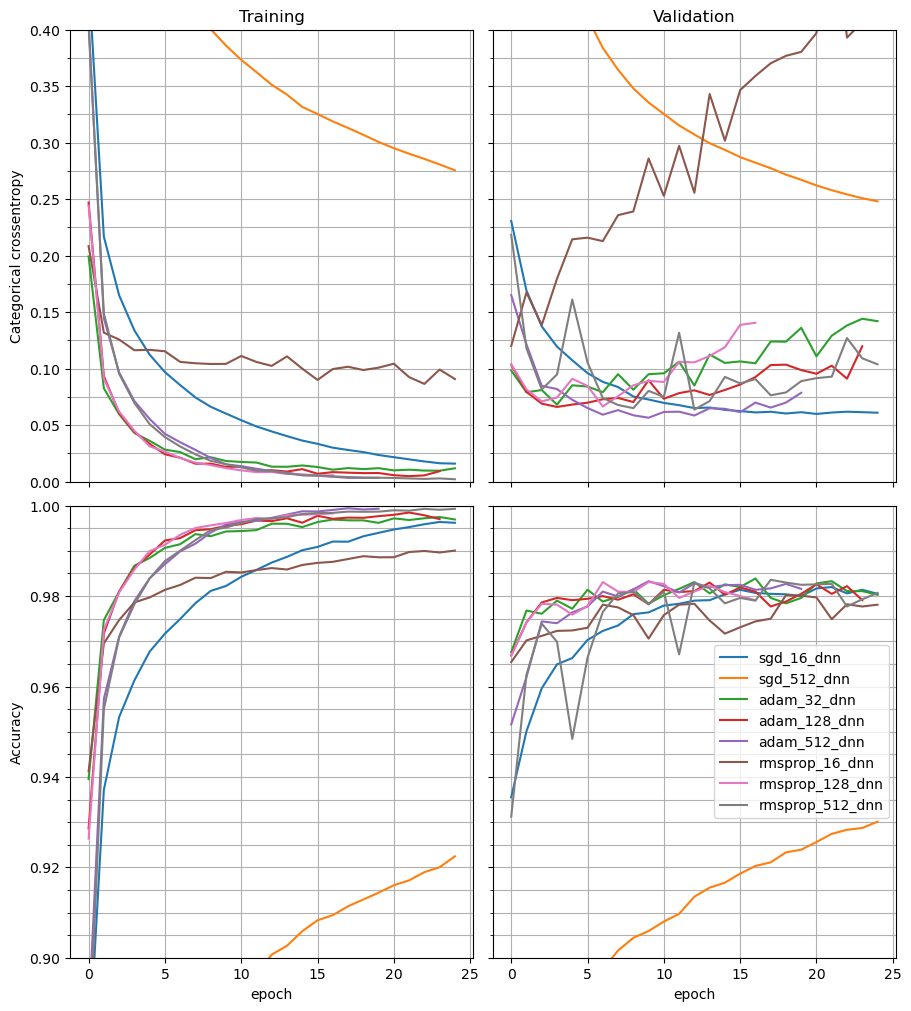

In [3]:
# Showing training history
fig, axes = plt.subplots(
    2, 2,
    sharex=True,
    sharey="row",
    dpi=100,
    figsize=(9, 10),
    constrained_layout=True,
)
plot_fits(
    {name: history for name, (_, history) in results.items()},
    axes,
)
axes[0, 0].set_yticks(np.arange(0.0, 0.4, 0.025), minor=True)
axes[0, 0].set_ylim(0.0, 0.4)
axes[1, 0].set_yticks(np.arange(0.9, 1.0, 0.005), minor=True)
axes[1, 0].set_ylim(0.9, 1.0)


The model performance is greatly affected by the optimizer. Sophisticated optimizers (`adam`, `rmsprop`) converges to the optimal solution faster in this scenario, while `sgd` seems to provide more stable results. The batch size has a considerable impact only when using `sgd`.

The confusion matrix is a popular metric to assess a classifier performance. It can be seen that the models mistake numbers that are similarly written (e.g. '4' and '9')

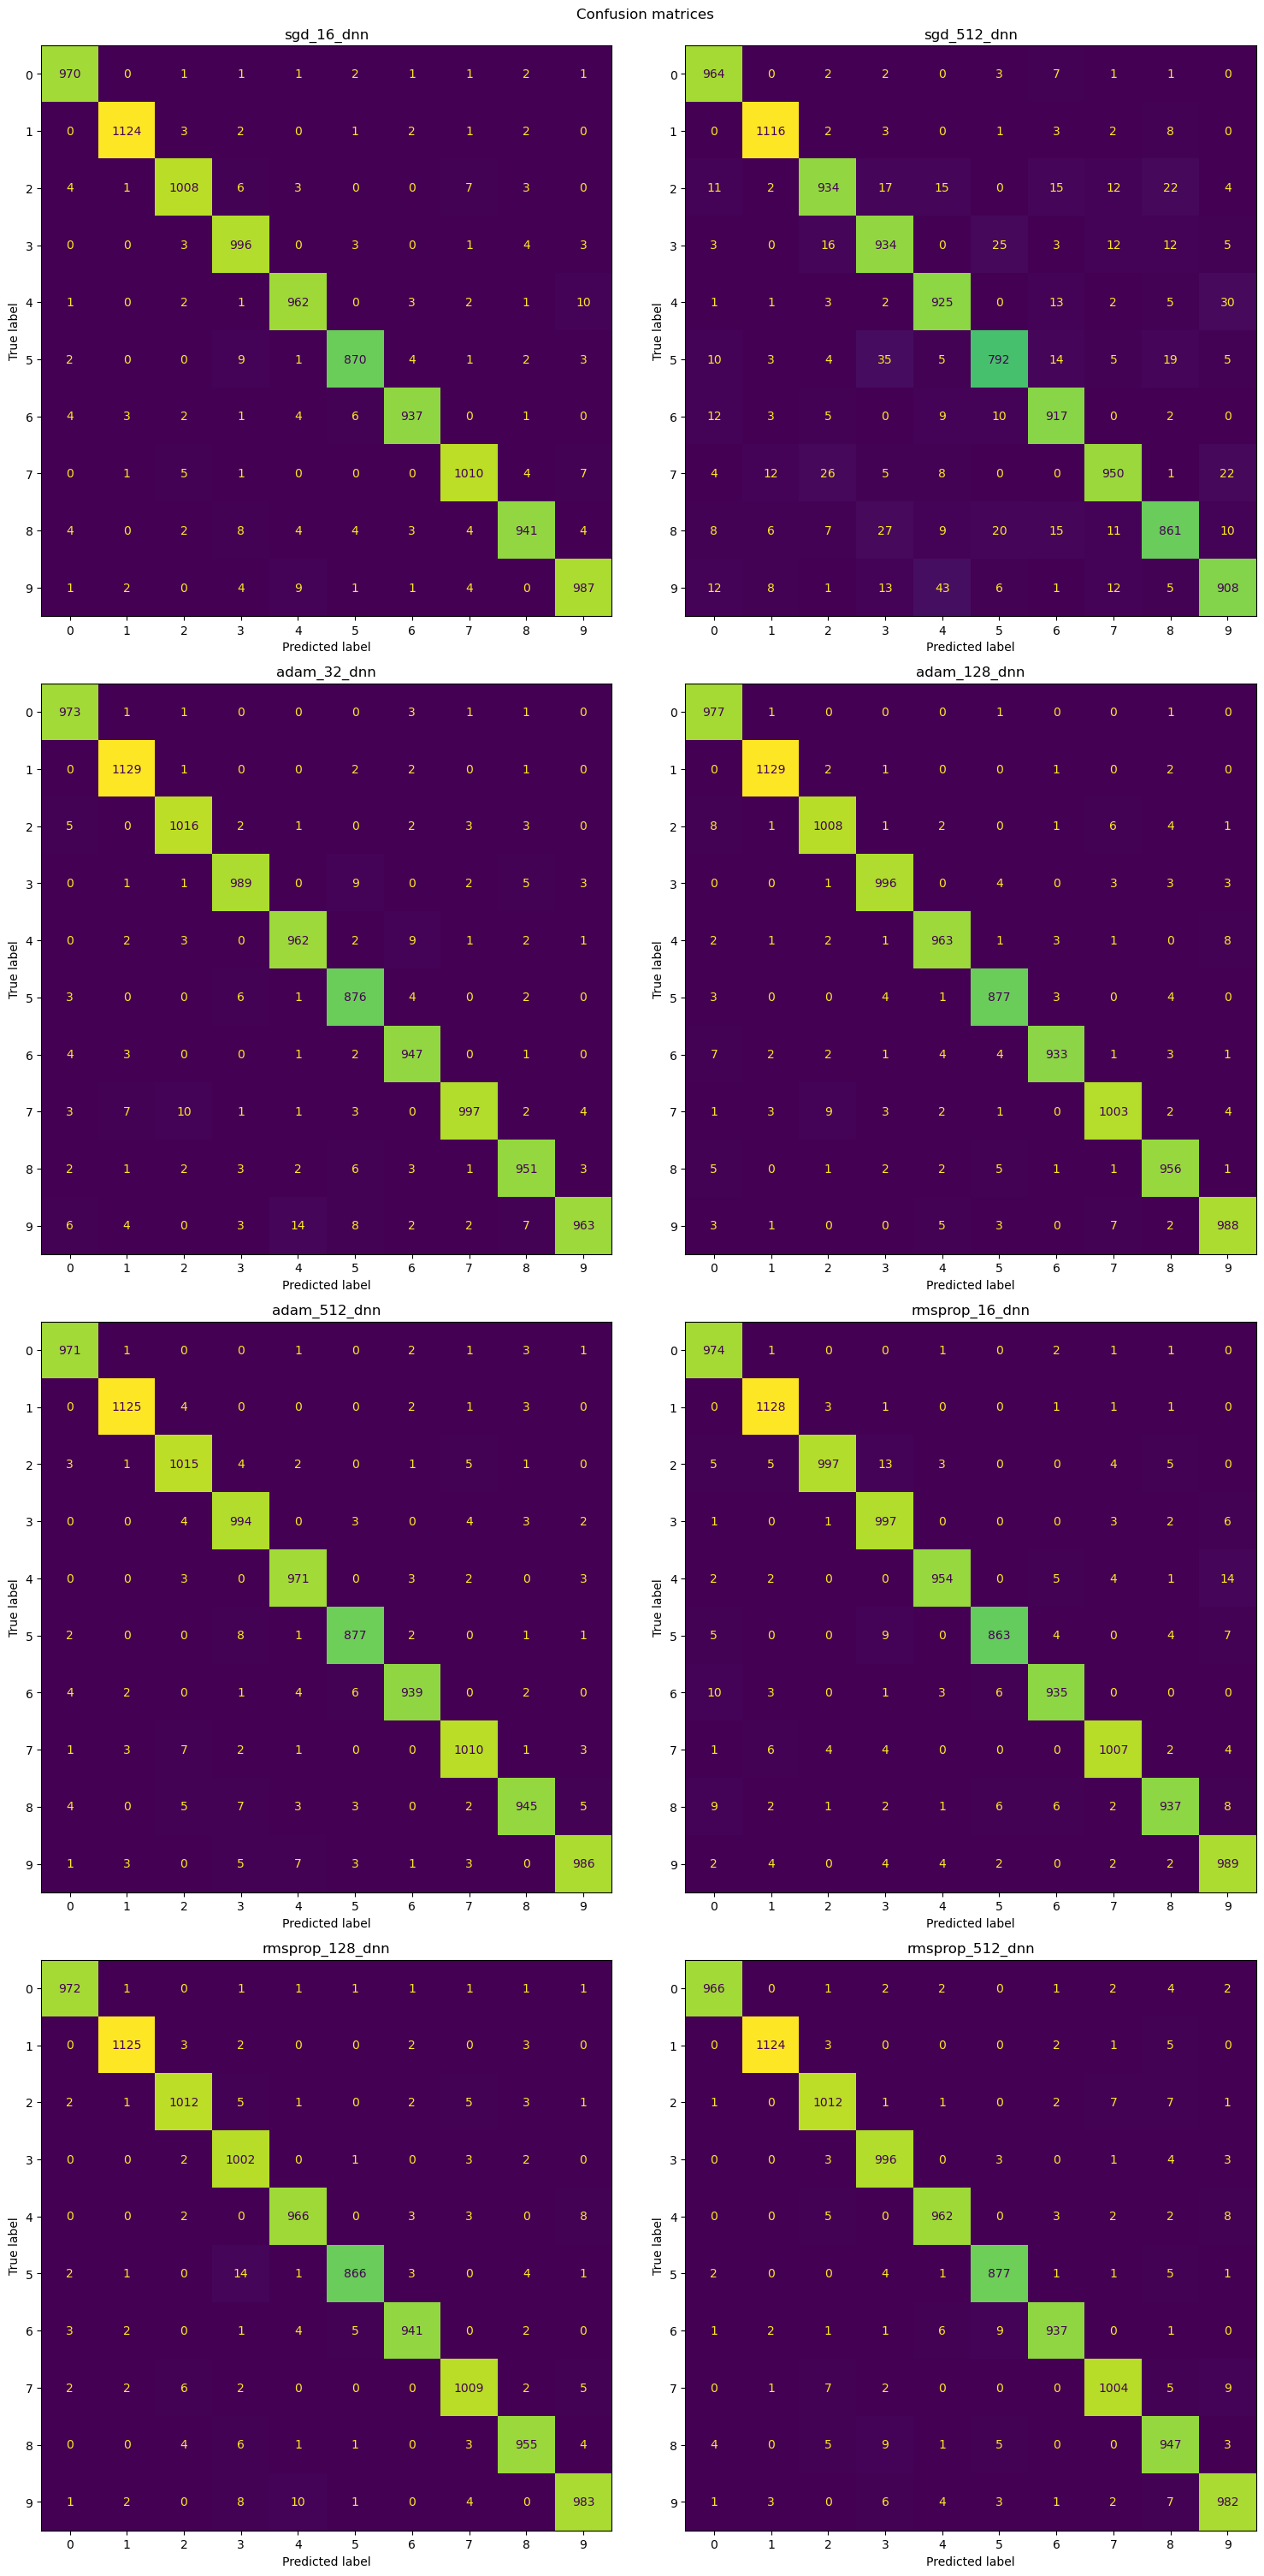

In [4]:
fig = plt.figure(figsize=(15, 30), dpi=100, constrained_layout=True)
plot_confusion_matrices(
    fig, [model for (model, _) in results.values()], x_test, y_test, rows=4, cols=2
)


The following plot shows some of the misclassified digits. It can be seen that many of them can easily be labeled correctly from a human perspective.

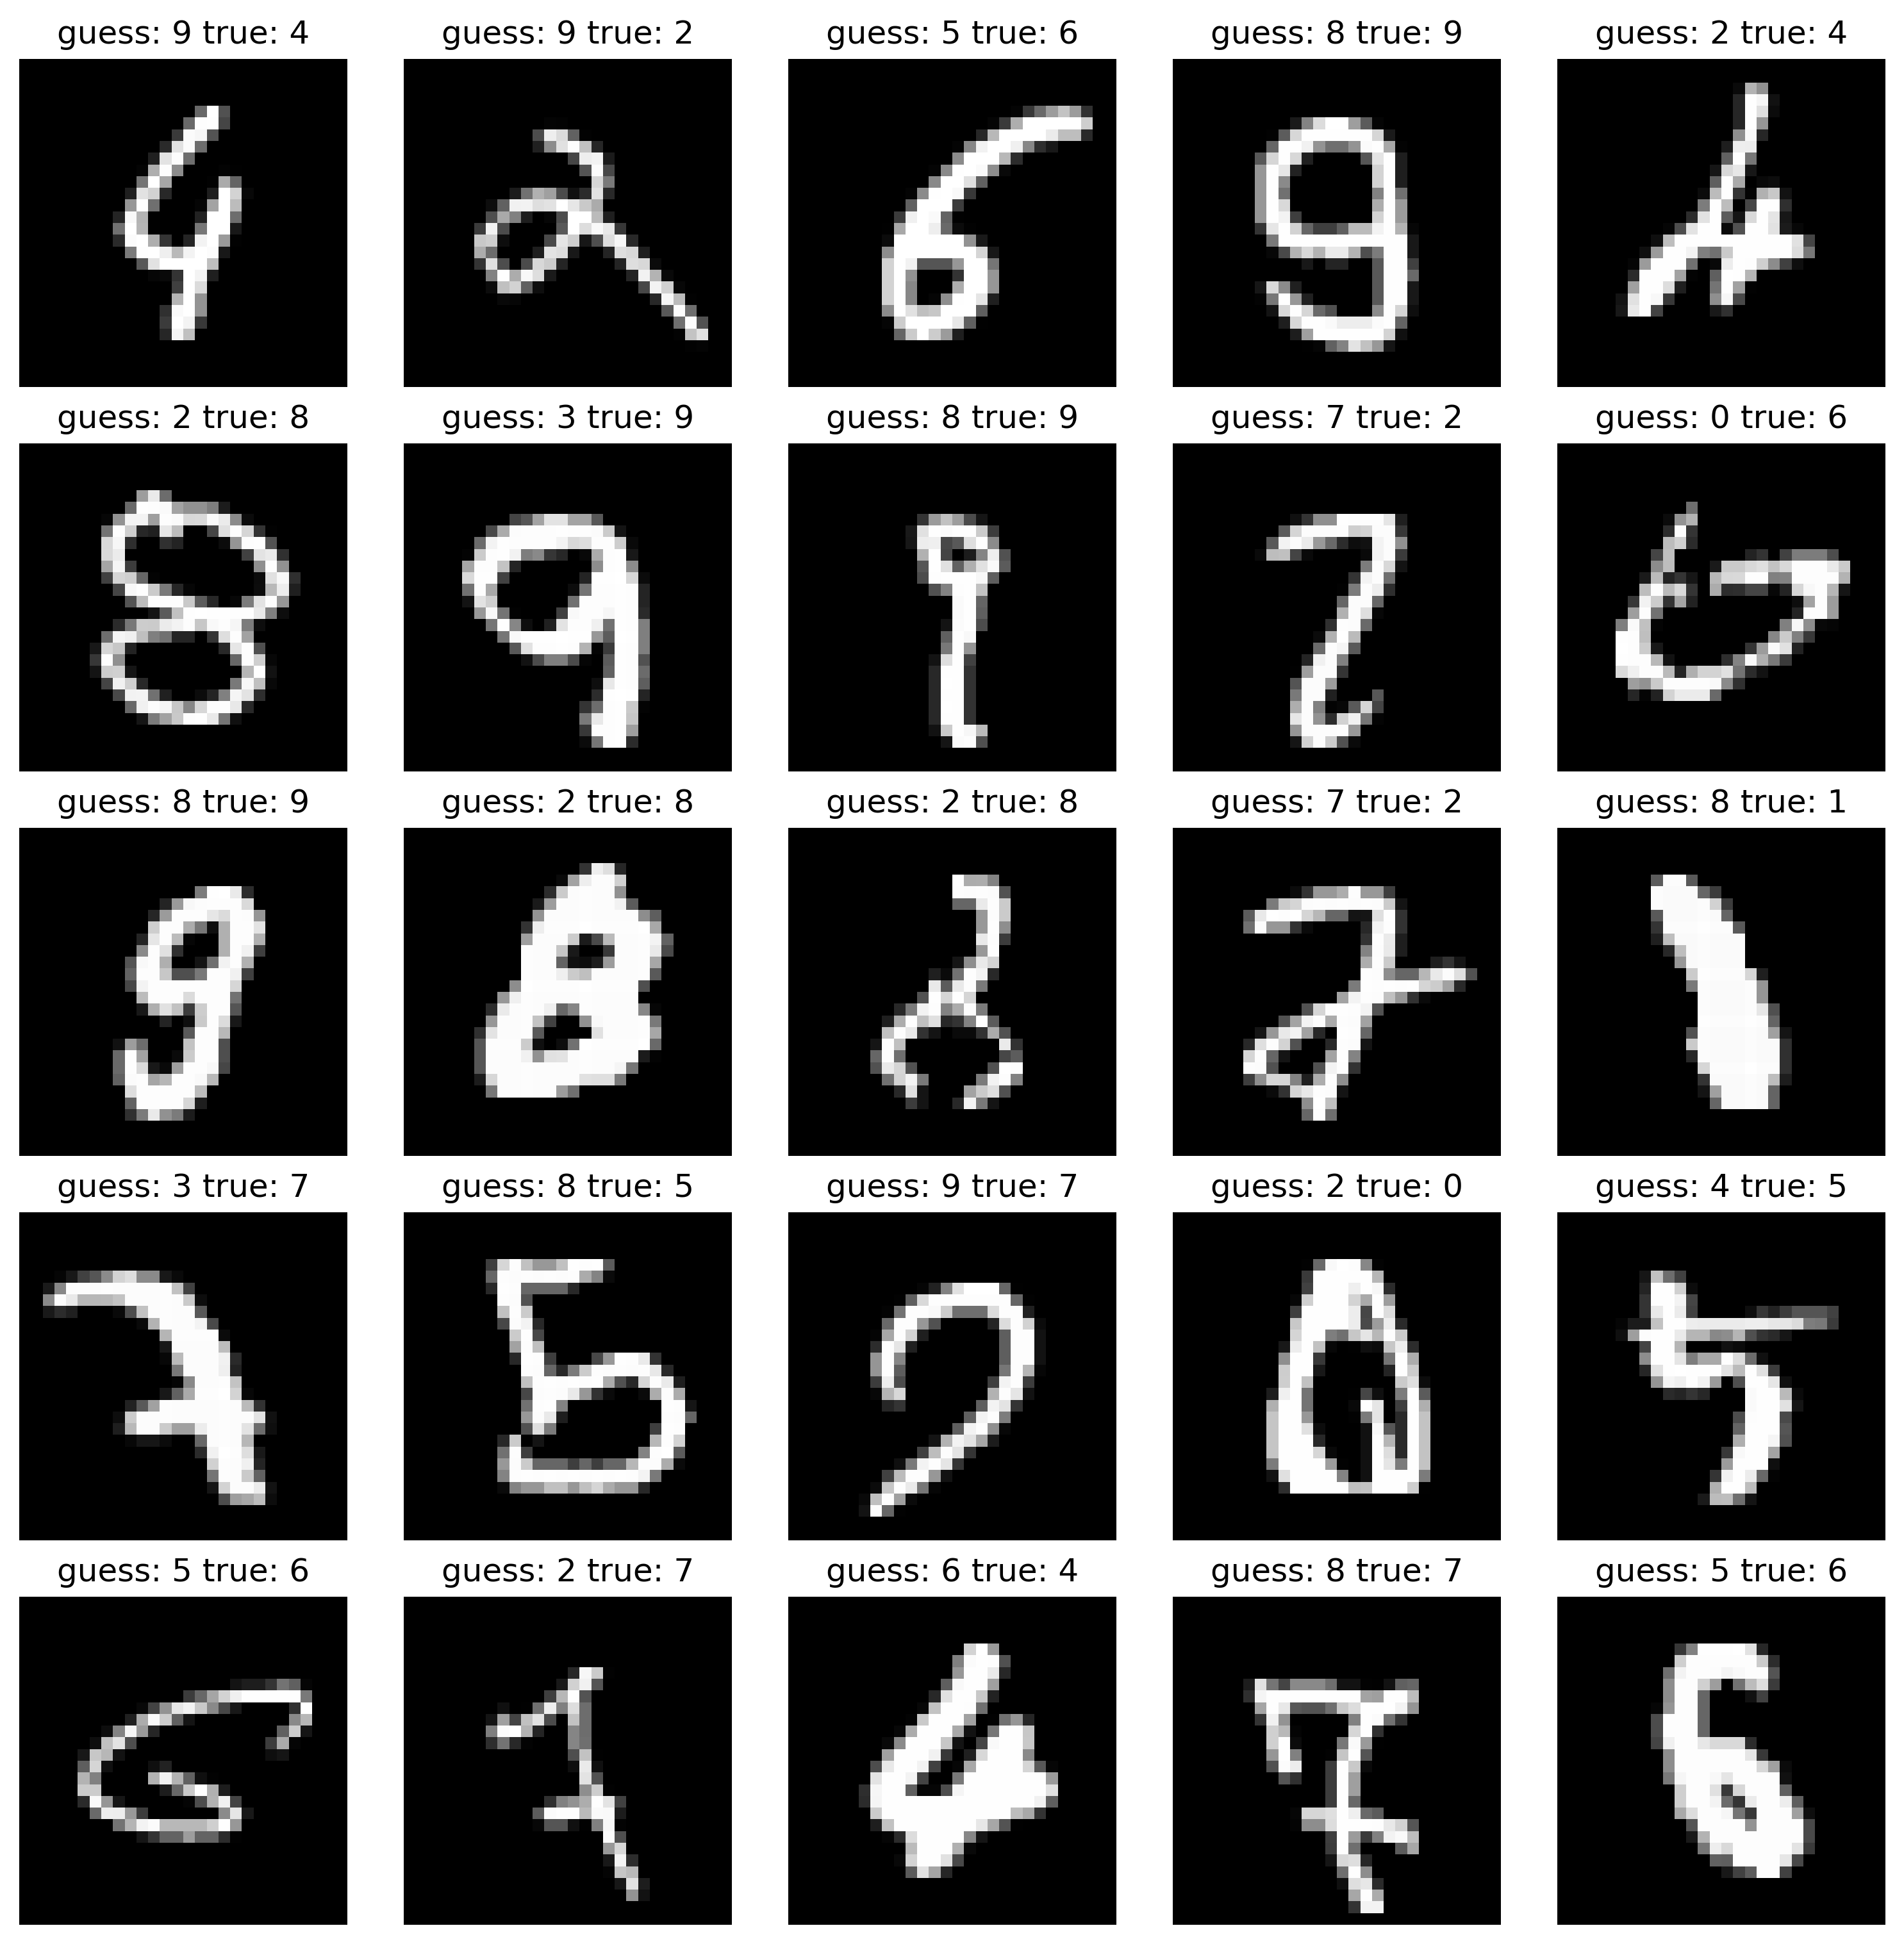

In [5]:
fig = plt.figure(dpi=300, figsize=(10, 10), constrained_layout=True)
plot_wrong_predictions(
    fig, results["rmsprop_512_dnn"][0], x_test, y_test, 5, 5, verbose=verbosity
)
